## This noteboook explores the data quality of the two Quandl data sets for Capstone project

In [19]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set(style="ticks", color_codes=True)

plt.rcParams["figure.figsize"] = [15.0,6.0]

### Exploring the fundamental data first

In [111]:
#The below is the first of the two quandl datasets I have subscribed to. This one contains core fundamental data for India 
### please unzip DEB.zip file in ./DEB to be able to run the below code ###
df = pd.read_csv('DEB\\DEB_20170718.csv', names = ['dataname','date','standalone','consolidated'], 
                 header = None, parse_dates = ['date'])


In [112]:
df.head()

,dataname,date,standalone,consolidated
0,20MICRONS_A_ACCRUALS,2005-03-31,-10.44,NaN
1,20MICRONS_A_ACCRUALS,2006-03-31,0.44,NaN
2,20MICRONS_A_ACCRUALS,2007-03-31,-2.61,NaN
3,20MICRONS_A_ACCRUALS,2008-03-31,-2.54,NaN
4,20MICRONS_A_ACCRUALS,2009-03-31,1.00,0.84


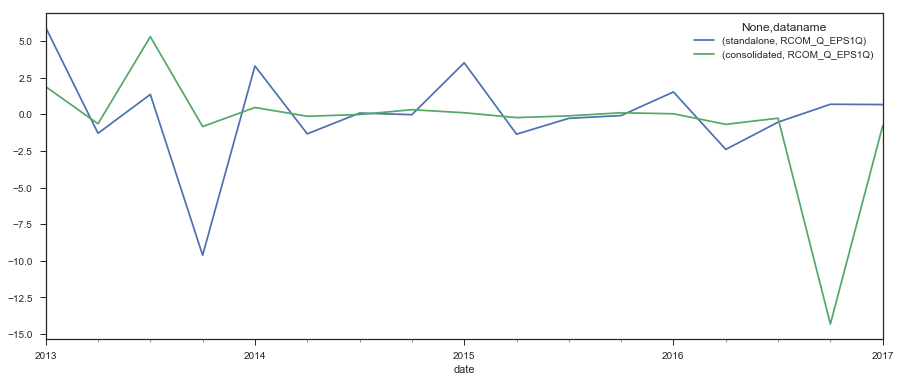

In [114]:
#First let us try to plot a specific feature to see if we can replicate the chart as seen on quandl
a = df[df.dataname == 'RCOM_Q_EPS1Q'].set_index(['date','dataname'])
a.unstack().plot()
#Awsome! have been able to replicate the chart of this from quandl.

In [6]:
len(df) # 9 million rows! 

9191479

In [115]:
dfsmall = df[df.date >= '2016-01-01']

In [116]:
len(dfsmall) 

1511903

In [125]:
#split the feature column into ticker, freq and indicator
splitfeature = dfsmall['dataname'].str.split('_')
splitfeature.head()

11    [20MICRONS, A, ACCRUALS]
23          [20MICRONS, A, AE]
35      [20MICRONS, A, ASETTO]
42       [20MICRONS, A, BBETA]
50        [20MICRONS, A, BSEC]
Name: dataname, dtype: object

In [9]:
splitfeature.apply(len).value_counts() # count how many strings is each dataname split into, after splitting by underscores

3    1469819
4      42084
Name: dataname, dtype: int64

In [10]:
# need to check why there are these 4 strings sometimes (dataname was supposed to be of the form ticker_freq_indicator) 

In [118]:
splitfeature[splitfeature.apply(len) == 4].head(10) # looks like the feature name is split by an underscore sometimes.

292        [20MICRONS, A, CFO, DEBT]
304       [20MICRONS, A, CFO, SALES]
433     [20MICRONS, A, DEBT, ASSETS]
445         [20MICRONS, A, DEBT, CE]
749       [20MICRONS, A, EV, ASSETS]
757          [20MICRONS, A, EV, CFO]
764           [20MICRONS, A, EV, NP]
1645        [20MICRONS, Q, DIV, PCT]
1646        [20MICRONS, Q, DIV, PCT]
1647        [20MICRONS, Q, DIV, PCT]
Name: dataname, dtype: object

In [119]:
#let us make sure the 2nd column always as A (Annual) and Q(Quarterly)
splitfeature.apply(lambda x: x[1]).value_counts()

Q    996503
A    515400
Name: dataname, dtype: int64

In [126]:
#So, thankfully the first string before _ is always company ticker, the second is always freq and indicator name is mostly without
#an underscore, but sometimes with an underscore.
splitfeature = dfsmall['dataname'].str.split('_').apply(lambda x: x if len(x)==3 else [x[0],x[1],x[2] + '_'+ x[3]] ) 

In [127]:
# again count how many strings are their after splitting by underscores
splitfeature.apply(len).value_counts() 

3    1511903
Name: dataname, dtype: int64

In [128]:
#Good, so now we have only three elements. Lets check what has happened to those locations where there were 4 elements
splitfeature[dfsmall['dataname'].str.split('_').apply(len) == 4].head(10)

292        [20MICRONS, A, CFO_DEBT]
304       [20MICRONS, A, CFO_SALES]
433     [20MICRONS, A, DEBT_ASSETS]
445         [20MICRONS, A, DEBT_CE]
749       [20MICRONS, A, EV_ASSETS]
757          [20MICRONS, A, EV_CFO]
764           [20MICRONS, A, EV_NP]
1645        [20MICRONS, Q, DIV_PCT]
1646        [20MICRONS, Q, DIV_PCT]
1647        [20MICRONS, Q, DIV_PCT]
Name: dataname, dtype: object

In [129]:
# success: the 3rd and 4th items are merged back like CFO_DEBT 
#ok time to convert this into a dataframe
splitfeature_df = pd.DataFrame(splitfeature.tolist(),columns = ['ticker','freq','indicator'])
#pd.DataFrame(splitfeature.tolist(),columns = {'ticker','freq','indicator'}), dfsmall],axis=1)
splitfeature_df.head()

,ticker,freq,indicator
0,20MICRONS,A,ACCRUALS
1,20MICRONS,A,AE
2,20MICRONS,A,ASETTO
3,20MICRONS,A,BBETA
4,20MICRONS,A,BSEC


In [130]:
dfsmall.shape

(1511903, 4)

In [131]:
pd.concat([dfsmall, splitfeature_df], axis = 1).head(5) #Ah, understood why this is not working. The indices are different!

,dataname,date,standalone,consolidated,ticker,freq,indicator
0,NaN,NaT,NaN,NaN,20MICRONS,A,ACCRUALS
1,NaN,NaT,NaN,NaN,20MICRONS,A,AE
2,NaN,NaT,NaN,NaN,20MICRONS,A,ASETTO
3,NaN,NaT,NaN,NaN,20MICRONS,A,BBETA
4,NaN,NaT,NaN,NaN,20MICRONS,A,BSEC


In [132]:
#Make indices same
splitfeature_df.set_index(dfsmall.index,inplace=True)


In [133]:
#now put them next to each other
dfsmall_split = pd.concat([dfsmall, splitfeature_df], axis = 1)
dfsmall_split.head(5)

,dataname,date,standalone,consolidated,ticker,freq,indicator
11,20MICRONS_A_ACCRUALS,2016-03-31,-9.0700,-14.4400,20MICRONS,A,ACCRUALS
23,20MICRONS_A_AE,2016-03-31,3.8300,3.8900,20MICRONS,A,AE
35,20MICRONS_A_ASETTO,2016-03-31,3.9933,4.1181,20MICRONS,A,ASETTO
42,20MICRONS_A_BBETA,2016-03-31,0.7458,0.7458,20MICRONS,A,BBETA
50,20MICRONS_A_BSEC,2016-03-31,28.4500,28.4500,20MICRONS,A,BSEC


In [134]:
#ok, we can verify above that dataname has been broken correctly into ticker freq and indicator
#now, drop the redundant dataname and reorder columns
dfn = dfsmall_split[['date', 'ticker', 'freq', 'indicator','standalone', 'consolidated']]
dfn.head(5)

,date,ticker,freq,indicator,standalone,consolidated
11,2016-03-31,20MICRONS,A,ACCRUALS,-9.0700,-14.4400
23,2016-03-31,20MICRONS,A,AE,3.8300,3.8900
35,2016-03-31,20MICRONS,A,ASETTO,3.9933,4.1181
42,2016-03-31,20MICRONS,A,BBETA,0.7458,0.7458
50,2016-03-31,20MICRONS,A,BSEC,28.4500,28.4500


In [135]:
dfn.shape

(1511903, 6)

In [136]:
all(dfn.index == dfsmall.index)

True

In [137]:
#Why are these index values not consecutive? 
dfn.index[0:100]

Int64Index([  11,   23,   35,   42,   50,   58,   66,   74,   82,   94,  105,
             114,  121,  133,  145,  157,  169,  181,  193,  205,  217,  228,
             237,  244,  256,  268,  280,  292,  304,  316,  328,  340,  352,
             364,  376,  388,  409,  421,  433,  445,  457,  478,  486,  488,
             504,  516,  524,  545,  556,  565,  572,  584,  596,  607,  616,
             623,  635,  646,  655,  662,  674,  686,  709,  717,  725,  733,
             741,  749,  757,  764,  772,  784,  796,  808,  820,  832,  844,
             856,  863,  870,  882,  890,  902,  914,  926,  938,  949,  958,
             965,  977,  989, 1001, 1013, 1025, 1036, 1045, 1052, 1063, 1072,
            1079],
           dtype='int64')

In [138]:
df.index[0:1000] #wow, these are all consecutive but if you take dates > some date, then they are no longer consecutive. 

RangeIndex(start=0, stop=1000, step=1)

In [139]:
#ok, so it clearly means that the original data is not sorted by date. let us do the sorting of the dfn. 
dfn = dfn.sort_values(['date','ticker','freq','indicator'])

In [140]:
#how many tickers are there in the data? 
len(dfn.ticker.unique())

3950

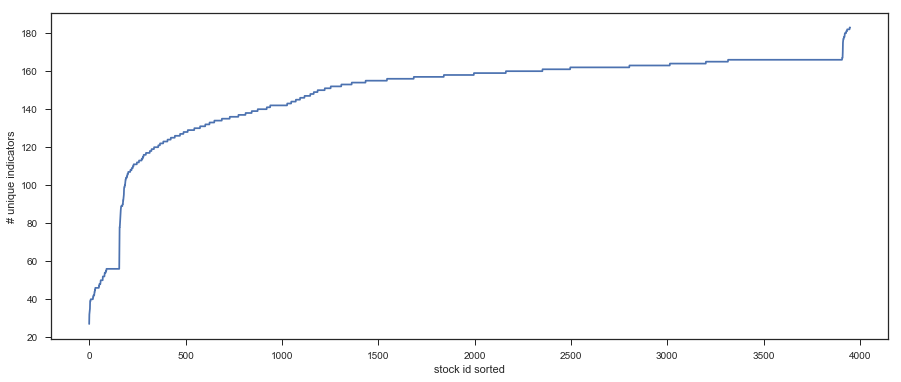

In [141]:
#how many distinct indicators are present per ticker, sort them and plot 
tickerIndicators = dfn.groupby('ticker').apply(lambda x: len(x.indicator.unique()))
tickerIndicators.sort_values(ascending=True,inplace=True)
plt.plot(tickerIndicators.values)
plt.ylabel('# unique indicators') 
plt.xlabel('stock id sorted') 

In [142]:
#how many nulls are there in each colum
dfn.groupby('indicator').apply(lambda x: x.isnull().sum()).head(10)
#looks like only consolidated column has missing values

,date,ticker,freq,indicator,standalone,consolidated
indicator,,,,,,
ACCRUALS,0,0,0,0,0,2484
ADV,0,0,0,0,0,18
ADVYIELD,0,0,0,0,0,18
AE,0,0,0,0,0,2466
ASETTO,0,0,0,0,0,2466
ATM,0,0,0,0,0,65
BBETA,0,0,0,0,0,1515
BRANCH,0,0,0,0,0,66
BSEC,0,0,0,0,0,14846


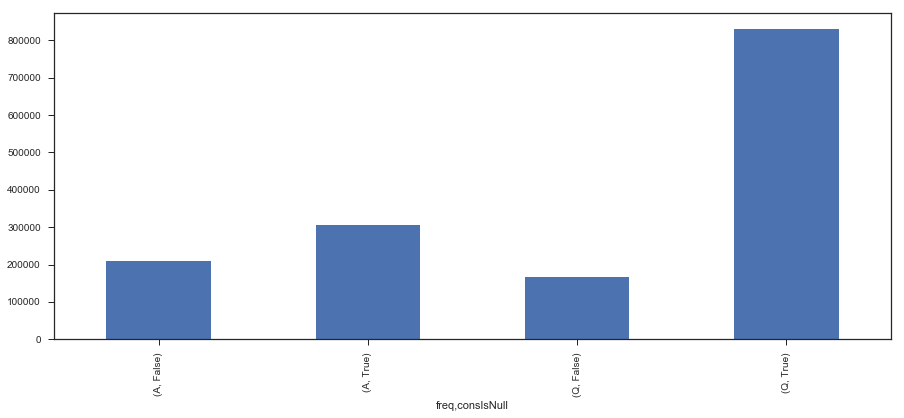

In [143]:
#let us see if there is a pattern in where the consolidated column is null
dfn['consIsNull'] = dfn.consolidated.isnull()
grouped = dfn.groupby(['freq','consIsNull'])
grouped.size().plot(kind='bar')

In [144]:
#For a financial info released with Annual frequency, 'consolidated' result is 1.5 times more likely to be null than not. 
#For a financial info released with Quarterly frequency, 'consolidated' result is 4 times more likely to be null than not.

In [145]:
#lets see if there is a pattern in dates, when this data gets released
dfn['date'].dt.month.value_counts() 

3     902421
6     204355
12    203703
9     201424
Name: date, dtype: int64

In [146]:
#only 4 months! not unexpected because Indian fundamental data is to be released quarterly. Lets get down to dates now.
dfn['date'].value_counts()

2016-03-31    686212
2017-03-31    216209
2016-12-31    203703
2016-06-30    203054
2016-09-30    201424
2017-06-30      1301
Name: date, dtype: int64

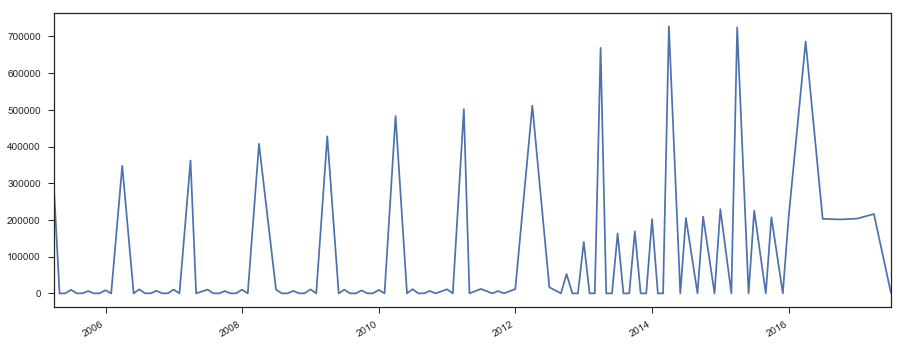

In [147]:
#something surely looks odd. How can all data release exactly on the last day of the Quarter? This is surely wrong as per
#quick googling!! lets check in the orignal dataframe df
df['date'].value_counts().plot()

### Lets explore the second data set, i.e. price and volume history

In [149]:
#The below is the first of the two quandl datasets I have subscribed to. This one contains core fundamental data for India 
### please unzip TC1.zip file in ./DEB to be able to run the below code ###
prc = pd.read_csv('TC1\\TC1_20170717.csv', 
                 names = ['ticker','date','open','high','low','last','close','volume','valueTraded'],
                 header = None, parse_dates = ['date'])


In [150]:
prc.head(5)

,ticker,date,open,high,low,last,close,volume,valueTraded
0,20MICRONS,2008-10-06,40.00,40.00,15.80,16.78,16.83,23501730.0,4849.07
1,20MICRONS,2008-10-07,16.00,19.00,13.93,15.03,15.05,9113422.0,1435.99
2,20MICRONS,2008-10-08,14.00,14.60,12.55,13.20,13.25,2464384.0,330.90
3,20MICRONS,2008-10-10,12.45,12.45,10.83,11.83,11.60,1207928.0,141.93
4,20MICRONS,2008-10-13,12.15,13.30,11.65,12.35,12.33,898692.0,114.01


In [151]:
#how many distinct tickers are there in this data?
len(prc.ticker.unique())

1480

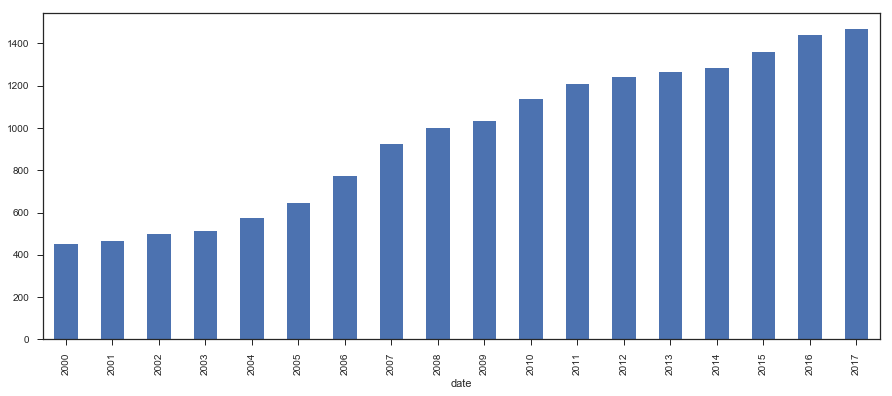

In [152]:
#how many distinct tickers are there in each calendar year of data?
prc['ticker'].groupby(prc.date.dt.year).apply(lambda x: len(x.unique())).plot(kind = 'bar')

## plot close prices of top 200 tickers by average daily value traded in this dataset.


In [92]:
#filter out top200 most liquid stock's close price data
vt = prc.loc[prc.date>='2010-01-01',['ticker','valueTraded']].groupby('ticker').mean()
top200 = vt['valueTraded'].sort_values(ascending = False).head(200)
prcfilt = prc.loc[prc.ticker.isin(top200.index) & (prc.date>='2010-01-01'),['date','ticker','close']]


In [61]:
#Transform the data so that each price begins with 100. 
#This gets tricky because not every stock is present from day 1, some got listed only recently
#So first we need to fill backfill nans with initial closing price and then we need to 100 base each stock price
#All these manipulations are much easier to do by bringing all stock prices into separate columns
prcNorm = prcfilt.set_index(['date','ticker']).unstack().fillna(method='bfill').apply(lambda x:100*x/x[0]).stack().reset_index()

In [68]:
#add a column called liquidity having values 1 to 25, 25 being most liquid
top200df = pd.DataFrame(top200).reset_index()
top200df['liquidityRank'] = 1+ np.floor(top200df.index/8)
top200df.drop('valueTraded',axis=1,inplace=True)
prcNorm = prcNorm.merge(top200df,on='ticker',how='left')


In [69]:
#write a function to plot the price chart of all stocks in the liquidity bucket that is input
def chartStocks(df, liq, **kwargs):
    if 'col' in kwargs:
        col_to_plot = kwargs.pop('col')
    else:
        col_to_plot = 'close'
    dffilt = df.loc[df.liquidityRank == liq,['date','ticker',col_to_plot]]
    dffilt.set_index(['date','ticker']).unstack().plot()
    plt.legend()
    plt.grid()
    

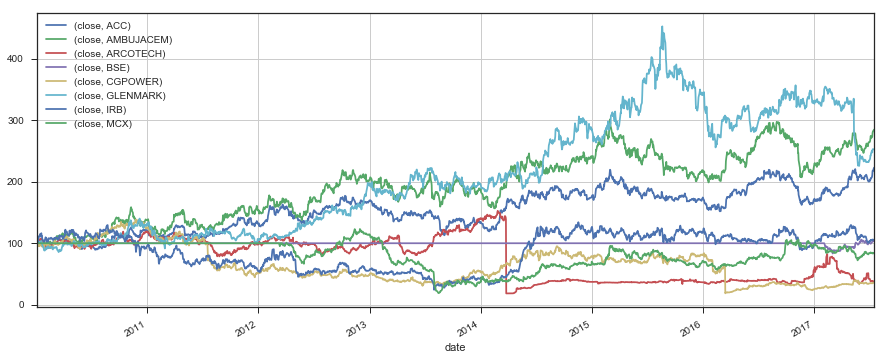

In [85]:
## Below is a nice tool to plot normalized prices of stocks (top200 by value traded) in groups of 8 
#to check if all is well with this data set. 
chartStocks(prcNorm,14)  #keep changing the second input from 1 to 25

In [109]:
#Oh, why is there a massive jump down in ARCOTECH? (chartStocks(prcNorm, 14))In a corporate action adjusted data there 
#shouldnt be huge jumps because stock splits etc are already adjusted for, and if a stock genuinely moves in one day by 
#so much, circuit breaker rules will halt its trading

#lets have a closer look around this time window
prc.loc[(prc.ticker == 'ARCOTECH')&(prcfilt.date > '2014-03-21')&(prcfilt.date < '2014-04-22'),:]

,ticker,date,open,high,low,last,close,volume,valueTraded
215128,ARCOTECH,2014-03-22,273.03,274.71,271.20,273.99,273.87,221161.28,604.84
215129,ARCOTECH,2014-03-24,274.52,276.44,269.78,270.70,270.58,2175247.58,5934.06
215130,ARCOTECH,2014-03-25,267.96,269.20,262.57,263.15,263.70,4785932.86,12739.97
215131,ARCOTECH,2014-04-16,34.80,35.08,34.80,35.00,35.00,57855.00,20.26
215132,ARCOTECH,2014-04-17,35.01,35.32,34.30,35.20,35.20,63020.00,21.80
215133,ARCOTECH,2014-04-21,35.30,42.20,35.30,35.80,35.91,128105.00,46.15


In [ ]:
#ok some googling reveals that this stock got listed in NSE in April 2014. Before that only BSE. So does this vendor contain BSE
#data if stock not listed on NSE? Asked quandl and vendor the question

In [ ]:
## So, we have been able to find out two problems one in each dataset by methodically exploring the data!